In [1]:
import numpy as np
from autograd import Tensor
from autograd.datautil import fetch_mnist
X_train, Y_train, X_test, Y_test = fetch_mnist()
X_train = X_train.reshape((-1, 784))


ModuleNotFoundError: No module named 'autograd'

In [2]:
class Criterion(object):
    def __call__(self, preds, targets):
        return self.apply(preds, targets)
    
    def apply(self, *args, **kwargs):
        raise NotImplementedError(
        f'user defined Criterion object has not implemented apply method')


class MSELoss(Criterion):
    def apply(self, preds, targets):
        errors = preds.sub(targets)
        return errors.pow(Tensor([2])).mean()

    
class NLLLoss(Criterion):
    def apply(self, logits, targets):
        n_classes = logits.shape[-1]
        y = np.zeros((targets.shape[0], n_classes)).astype(np.float32)
        y[range(y.shape[0]), targets] = -1.0 * n_classes
        targets = Tensor(y)
        return logits.mul(targets).mean()


In [3]:
class Optimizer(object):
    def __init__(self, parameters):
        self.parameters = parameters
    
    def zero_grad(self):
        for param in self.parameters:
            param.grad = None
    
    def step(self):
        raise NotImplementedError(
        f'user defined Optimizer object has not implemented gradient update')


class SGD(Optimizer):
    def __init__(self, parameters, lr=1e-3):
        super().__init__(parameters)
        self.lr = lr
    
    def step(self):
        for param in self.parameters:
            param.data -= self.lr * param.grad


In [4]:
class NN(object):
    def __call__(self, x):
        return self.forward(x)
    
    def forward(self, x):
        raise NotImplementedError(
        f'user defined NN module has not implemented forward pass')
    
    def parameters(self):
        params = []
        for value in self.__dict__.values():
            if isinstance(value, Tensor):
                if value.requires_grad:
                    params.append(value)
        return params
        

class Net(NN):
    def __init__(self):
        self.l1 = Tensor.uniform(784, 128)
        self.l2 = Tensor.uniform(128, 10)
    
    def forward(self, x):
        return x.dot(self.l1).relu().dot(self.l2).logsoftmax()


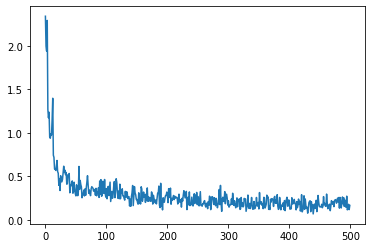

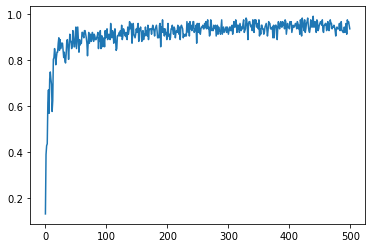

In [5]:
model = Net()
optimizer = SGD(model.parameters(), lr=1e-3)
criterion = NLLLoss()
epochs = 500
batch_size = 128
losses = []
accs = []

for epoch in range(epochs):
    indices = np.random.randint(0, X_train.shape[0], size=(batch_size))
    samples = Tensor(X_train[indices])
    targets = Y_train[indices]
    
    logits = model(samples)
    loss = criterion(logits, targets)
    losses.append(loss.data)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    cat = np.argmax(logits.data, axis=-1)
    acc = (cat == targets).mean()
    accs.append(acc)

    
import matplotlib.pyplot as plt
plt.plot(losses)
plt.show()
plt.plot(accs)
!